In [1]:
from naivePerStop import NaivePerStopRegressor
selected_model = NaivePerStopRegressor

In [1]:
from naive import NaiveRegressor
selected_model = NaiveRegressor

[' 125960550_f30avg', ' 230565994_f30avg', ' 258781031_f30avg', ' 43768720_f30avg', ' 44072192_f30avg', ' 44783654_f30avg', ' 44783914_f30avg', ' 44784438_f30avg', ' 45833547_f30avg', ' 47568123_f30avg']


100%|██████████| 21840/21840 [00:13<00:00, 1560.96it/s]


Final MAE: 3.897
Final RMSE: 10.593


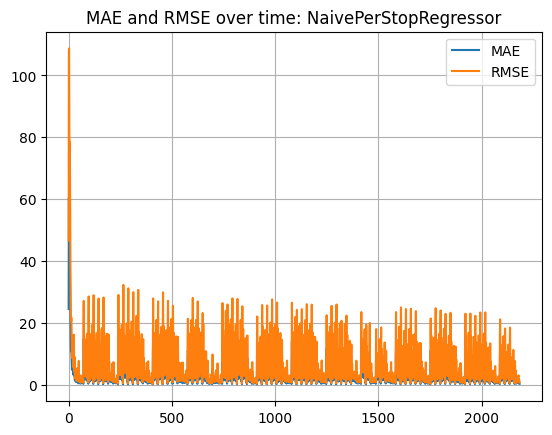

In [2]:
'''
============ Evaluating Model ============
'''

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # Not needed, shows progress bar

# Load in csv as dataframe
df = pd.read_csv("../loader_f30avg.csv", index_col=0)

# Get all stop ids
stop_ids = df.columns.to_list()

stop_ids = [i for i in stop_ids if "_f30avg" in i]

print(stop_ids)

# Init model
model = selected_model(stop_ids)

# Keeping track of errors
total_abs_error = 0.0
total_squared_error = 0.0
count = 0

# Window error tracking
error_window = 100
abs_error_buf = 0.0
sqrd_error_buf = 0.0
buf_count = 0
mae_list = []
rmse_list = []

# Loop over values send to regressor as stream
for _, row in tqdm(df.iterrows(), total=len(df)):
    for stop_id in stop_ids:
        value = row[stop_id]

        # Predict and get error
        pred = model.predict(stop_id)
        error = pred - value

        # Update total errors
        total_abs_error += abs(error)
        total_squared_error += error ** 2
        count += 1

        # Update buf errors
        abs_error_buf += abs(error)
        sqrd_error_buf += error ** 2
        buf_count += 1

        # Train on instance
        model.train(stop_id, value)

        # Add windowed error
        if buf_count == error_window:
            mae = abs_error_buf / error_window
            rmse = np.sqrt(sqrd_error_buf / error_window)
            mae_list.append(mae)
            rmse_list.append(rmse)

            # Reset
            abs_error_buf = 0.0
            sqrd_error_buf = 0.0
            buf_count = 0

# Get final metrics
mae = total_abs_error / count
rmse = np.sqrt(total_squared_error / count)

print(f"Final MAE: {mae:.3f}")
print(f"Final RMSE: {rmse:.3f}")

# Plot mae and rmse over windows
plt.figure()
plt.plot(mae_list, label="MAE")
plt.plot(rmse_list, label="RMSE")
plt.title("MAE and RMSE over time: "+selected_model.__name__)
plt.legend()
plt.grid(True)
plt.show()